In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
import pandas as pd

filepath = 'C:/AI_study/dataset/'
# Load all 9 files as a list
filenames = [
    'S01R01.txt', 'S01R02.txt', 'S02R01.txt', 'S02R02.txt', 'S03R01.txt', 'S03R02.txt',
    'S03R03.txt', 'S04R01.txt', 'S05R01.txt', 'S05R02.txt', 'S06R01.txt', 'S06R02.txt',
    'S07R02.txt', 'S08R01.txt', 'S09R01.txt', 'S10R01.txt'
]

# Create an empty list to store DataFrames
dfs = []

# Iterate over each filename, load the CSV file, and append the DataFrame to the list
for filename in filenames:
    df = pd.read_csv(filepath + filename, sep="\s+", header=None)
    user_number = int(filename[1:3])
    df['User_Number'] = user_number
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Set column names
columns = "TS, Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number".split(",")
df.columns = columns

print(df)

              TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
0             15        70       39     -970        0        0        0   
1             31        70       39     -970        0        0        0   
2             46        60       49     -960        0        0        0   
3             62        60       49     -960        0        0        0   
4             78        50       39     -960        0        0        0   
...          ...       ...      ...      ...      ...      ...      ...   
1798357  3020296      -131      107     -960        0        0        0   
1798358  3020312      -121      127     -970        0        0        0   
1798359  3020328      -141      117     -960        0        0        0   
1798360  3020343      -131      127     -980        0        0        0   
1798361  3020359      -141        0        0        0        0        0   

         Trunk_1  Trunk_2  Trunk_3  status  User_Number  
0              0        0        0       

In [3]:
df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
0,15,70,39,-970,0,0,0,0,0,0,0,1
1,31,70,39,-970,0,0,0,0,0,0,0,1
2,46,60,49,-960,0,0,0,0,0,0,0,1
3,62,60,49,-960,0,0,0,0,0,0,0,1
4,78,50,39,-960,0,0,0,0,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798362 entries, 0 to 1798361
Data columns (total 12 columns):
 #   Column       Dtype
---  ------       -----
 0   TS           int64
 1    Ankel_1     int64
 2   Ankel_2      int64
 3   Ankel_3      int64
 4   Thigh_1      int64
 5   Thigh_2      int64
 6   Thigh_3      int64
 7   Trunk_1      int64
 8   Trunk_2      int64
 9   Trunk_3      int64
 10  status       int64
 11  User_Number  int64
dtypes: int64(12)
memory usage: 164.6 MB


In [5]:
df.describe()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
count,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06
mean,1.077208e+06,-5.840035e+01,8.205787e+02,5.888554e+01,-2.079832e+01,6.020473e+02,-3.875299e+01,4.821141e+01,7.631992e+02,-1.167351e+02,6.525399e-01,5.211849e+00
std,7.637586e+05,5.273884e+02,4.954709e+02,5.610358e+02,5.378507e+02,4.358368e+02,4.883318e+02,2.827634e+02,4.226899e+02,4.159825e+02,5.879011e-01,2.897030e+00
min,1.500000e+01,-3.123400e+04,-3.276300e+04,-3.148800e+04,-2.184600e+04,-2.967300e+04,-2.431800e+04,-4.621000e+03,-3.400000e+03,-4.786000e+03,0.000000e+00,1.000000e+00
25%,4.390620e+05,-2.220000e+02,7.450000e+02,6.900000e+01,-2.630000e+02,2.590000e+02,-1.010000e+02,-8.700000e+01,7.800000e+02,-2.030000e+02,0.000000e+00,3.000000e+00
50%,9.293750e+05,-3.000000e+01,9.700000e+02,2.170000e+02,-1.800000e+01,6.290000e+02,9.000000e+01,2.900000e+01,9.520000e+02,-3.800000e+01,1.000000e+00,5.000000e+00
75%,1.621328e+06,1.210000e+02,1.019000e+03,3.260000e+02,2.180000e+02,9.620000e+02,2.420000e+02,1.940000e+02,1.009000e+03,1.160000e+02,1.000000e+00,8.000000e+00
max,3.058390e+06,3.072500e+04,3.200200e+04,3.174400e+04,2.662500e+04,3.259800e+04,2.841800e+04,6.707000e+03,2.429800e+04,4.339000e+03,2.000000e+00,1.000000e+01


In [6]:
df.columns

Index(['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3', 'status', 'User_Number'],
      dtype='object')

In [7]:
df['status'].value_counts()

status
1    959685
0    731768
2    106909
Name: count, dtype: int64

In [8]:
df.shape

(1798362, 12)

In [9]:
# status 열에서 값이 0인 행 제거
df = df[df['status'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['status'] = df['status'].replace({1: 0, 2: 1})

In [10]:
df.shape

(1066594, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


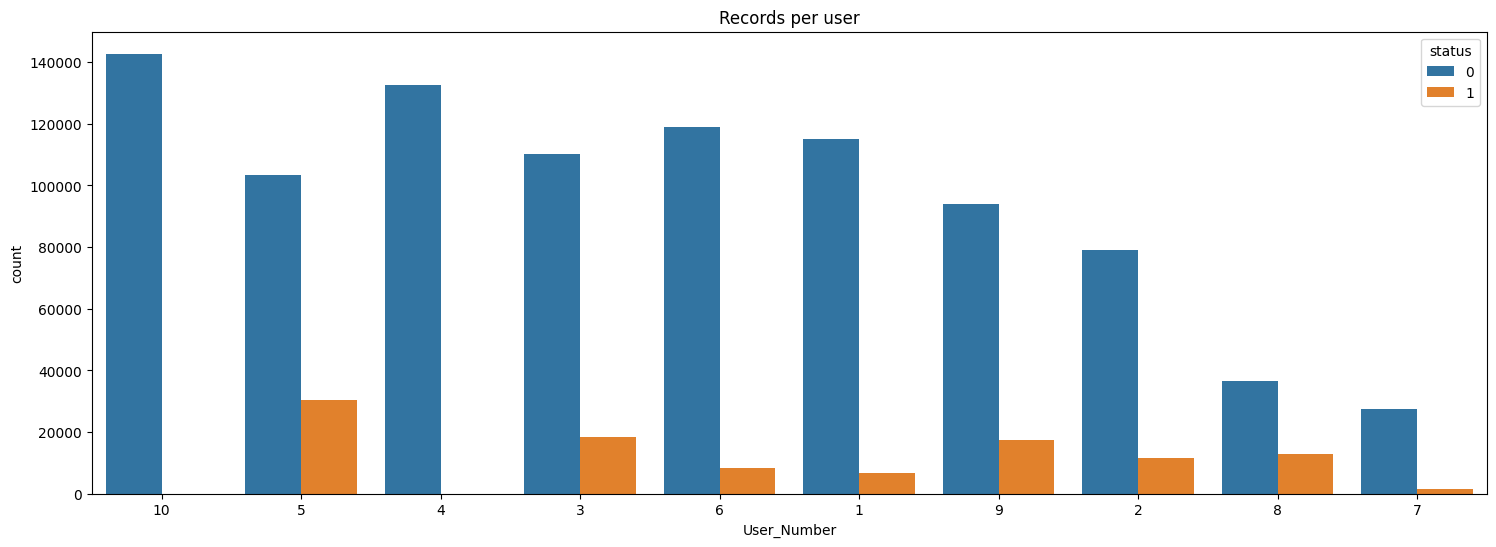

In [11]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']], df.status, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17062, 200, 10) (17062, 1)
(5332, 200, 10) (5332, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17062, 200, 10) (17062, 2) (5332, 200, 10) (5332, 2)


In [14]:
'''
X = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = df['status'].values.reshape(-1, 1)
'''

"\nX = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',\n       'Trunk_1', 'Trunk_2', 'Trunk_3']].values\ny = df['status'].values.reshape(-1, 1)\n"

In [15]:
'''
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
'''

'\nX_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)\nX_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )\nprint(X_train.shape, y_train.shape)\nprint(X_test.shape, y_test.shape)\n'

In [16]:
#Epoch 100

BATCH_SIZE = 128

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 10, 2)

In [17]:
'''from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)
'''

'from sklearn.preprocessing import OneHotEncoder\n\nenc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)\nenc.fit(y_train)\n\ny_train_hot = enc.transform(y_train) \ny_test_hot = enc.transform(y_test) \ny_val_hot = enc.transform(y_val)\n'

In [18]:
'''
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]
'''

'\nn_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]\n'

## Data Balancing 전 모델

In [21]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (n_timesteps,n_features),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200, 128)          71168     
                                                                 
 dropout_2 (Dropout)         (None, 200, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 64)           24640     
                                                                 
 dropout_3 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6336)              0         
                                                      

In [22]:
epochs, batch_size = 20, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/20
134/134 [==============================] - 9s 22ms/step - loss: 0.3696 - accuracy: 0.9010 - val_loss: 0.3972 - val_accuracy: 0.9018
Epoch 2/20
134/134 [==============================] - 2s 18ms/step - loss: 0.3259 - accuracy: 0.9017 - val_loss: 0.4160 - val_accuracy: 0.9018
Epoch 3/20
134/134 [==============================] - 2s 18ms/step - loss: 0.3248 - accuracy: 0.9017 - val_loss: 0.3955 - val_accuracy: 0.9018
Epoch 4/20
134/134 [==============================] - 2s 19ms/step - loss: 0.3254 - accuracy: 0.9017 - val_loss: 0.3808 - val_accuracy: 0.9018
Epoch 5/20
134/134 [==============================] - 3s 19ms/step - loss: 0.3237 - accuracy: 0.9017 - val_loss: 0.3913 - val_accuracy: 0.9018
Epoch 6/20
134/134 [==============================] - 2s 18ms/step - loss: 0.3271 - accuracy: 0.9017 - val_loss: 0.4232 - val_accuracy: 0.9018
Epoch 7/20
134/134 [==============================] - 2s 18ms/step - loss: 0.3257 - accuracy: 0.9017 - val_loss: 0.3989 - val_accuracy: 0.9018

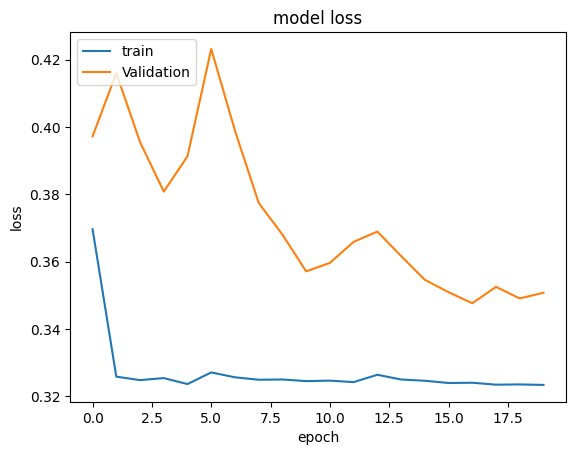

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

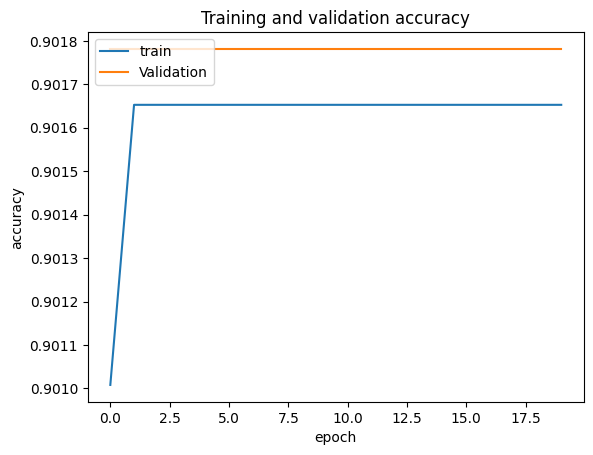

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

167/167 [==============================] - 2s 7ms/step
f1_score =  0.8551273913152845
0.9017254313578394
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4808
           1       0.00      0.00      0.00       524

    accuracy                           0.90      5332
   macro avg       0.45      0.50      0.47      5332
weighted avg       0.81      0.90      0.86      5332



I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

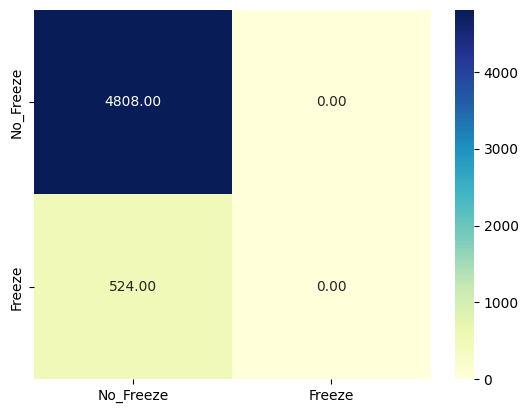

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Smote()를 통해 각 User 별로 status의 개수 동일하게 밸런싱

In [26]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 데이터프레임 그룹화
grouped = df.groupby('User_Number')

# 각 그룹에 대해 밸런싱 적용
balanced_dfs = []
for group_name, group_data in grouped:
    # 그룹 내 클래스 개수 확인
    num_classes = group_data['status'].nunique()
    
    # 클래스가 하나 이상인 경우에만 밸런싱 적용, Standing이 존재하지 않는 user가 있어서
    if num_classes > 1:
        # Smote를 통한 Oversampling
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(group_data.drop(['status', 'User_Number'], axis=1), group_data['status'])
        balanced_group_df = pd.concat([pd.DataFrame(X_resampled, columns=group_data.drop(['status', 'User_Number'], axis=1).columns),
                                       pd.DataFrame({'status': y_resampled})], axis=1)

        # 'user_id' 열 추가
        balanced_group_df['User_Number'] = group_name

        balanced_dfs.append(balanced_group_df)
    else:
        balanced_dfs.append(group_data)

# 재결합
balanced_df = pd.concat(balanced_dfs)

# 결과 확인
print(balanced_df.head())

       TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  Trunk_1  \
0  750000       -30      990      326      -45      972      181      -38   
1  750015       -30     1000      356      -18      981      212      -48   
2  750031       -20      990      336       18      981      222      -38   
3  750046       -20     1000      316       36      990      222      -19   
4  750062         0      990      316       36      990      212      -29   

   Trunk_2  Trunk_3  status  User_Number  
0     1000       29       0            1  
1     1028       29       0            1  
2     1038        9       0            1  
3     1038        9       0            1  
4     1038       29       0            1  


In [27]:
# 'Freeze' 활동을 하는 User_Number 추출
Freeze_users = balanced_df[balanced_df['status'] == 1]['User_Number'].unique()

# 'Freeze' 활동을 하지 않는 User_Number 추출
Freeze_absent_users = [User_Number for User_Number in df['User_Number'].unique() if User_Number not in Freeze_users]

# 'Freeze' 활동을 하지 않는 User_Number 해당하는 행 삭제
balanced_df = balanced_df[~balanced_df['User_Number'].isin(Freeze_absent_users)]

# 결과 확인
print(balanced_df)

             TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
0        750000       -30      990      326      -45      972      181   
1        750015       -30     1000      356      -18      981      212   
2        750031       -20      990      336       18      981      222   
3        750046       -20     1000      316       36      990      222   
4        750062         0      990      316       36      990      212   
...         ...       ...      ...      ...      ...      ...      ...   
188151   719786       296     1047       21     -213      913      206   
188152   457967       -14     1649      261     -802     1205      352   
188153   637802       233      923      -12       13      829      333   
188154  1010843       222     1008       98     -145      962      150   
188155   833621        -1      992      193     -316      894      228   

        Trunk_1  Trunk_2  Trunk_3  status  User_Number  
0           -38     1000       29       0            1

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


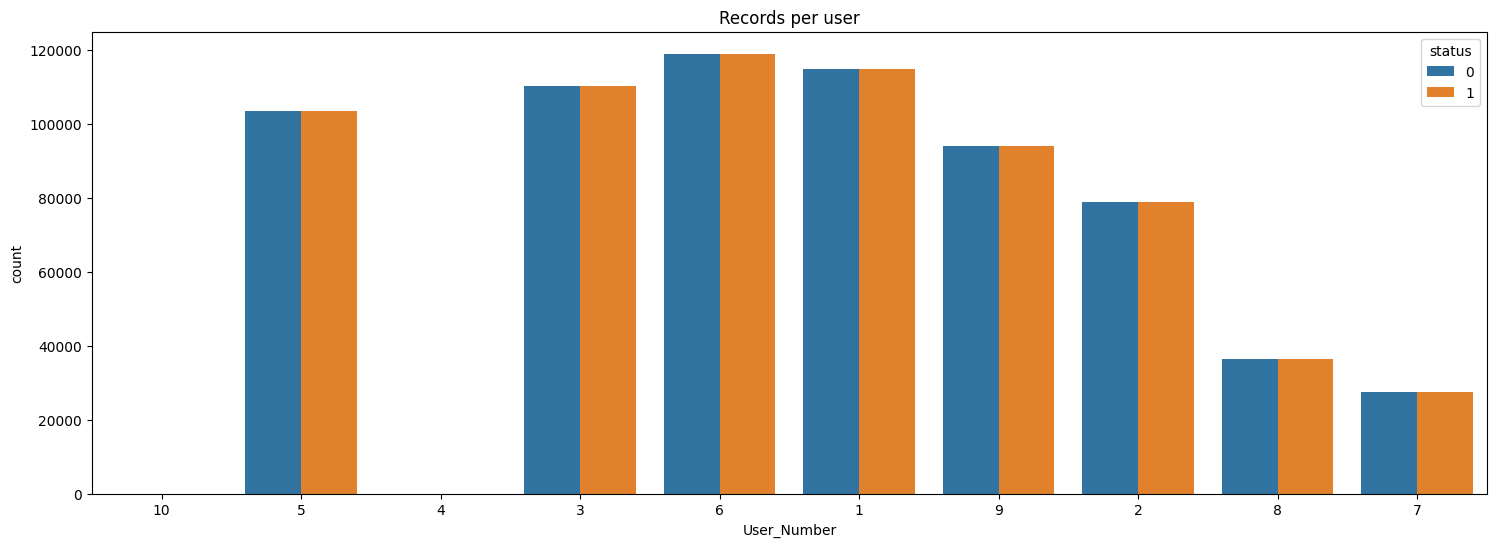

In [28]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = balanced_df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [29]:
print(balanced_df['User_Number'].value_counts())
print(balanced_df['User_Number'].value_counts())

User_Number
6    237904
1    229818
3    220608
5    206792
9    188156
2    157906
8     72850
7     54928
Name: count, dtype: int64
User_Number
6    237904
1    229818
3    220608
5    206792
9    188156
2    157906
8     72850
7     54928
Name: count, dtype: int64


In [30]:
## 9번 User의 행 개수에 맞춰서 다른 User의 행 개수 밸런싱 (앞의 밸런싱 유지)

In [31]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 데이터프레임 그룹화
grouped = df.groupby('User_Number')

# 각 그룹에 대해 밸런싱 적용
balanced_dfs = []
max_user_data_count = 188156  # 9번 User의 데이터 개수를 기준으로 설정

for group_name, group_data in grouped:
    # 그룹 내 클래스 개수 확인
    num_classes = group_data['status'].nunique()
    
    # 최소 데이터 개수를 가진 사용자를 기준으로 전체 데이터 개수 조절
    if num_classes > 1:
        # Smote를 통한 Oversampling
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(group_data.drop(['status', 'User_Number'], axis=1), group_data['status'])
        balanced_group_df = pd.concat([pd.DataFrame(X_resampled, columns=group_data.drop(['status', 'User_Number'], axis=1).columns),
                                       pd.DataFrame({'status': y_resampled})], axis=1)

        # 'user_id' 열 추가
        balanced_group_df['User_Number'] = group_name

        # 데이터 개수 조절
        balanced_group_df = balanced_group_df.sample(n=max_user_data_count, replace=True, random_state=42)

        balanced_dfs.append(balanced_group_df)
    else:
        # 데이터 개수 조절
        group_data = group_data.sample(n=max_user_data_count, replace=True, random_state=42)
        balanced_dfs.append(group_data)

# 재결합
balanced_df = pd.concat(balanced_dfs)

# 결과 확인
print(balanced_df.head())

# 'Freeze' 활동을 하는 User_Number 추출
Freeze_users = balanced_df[balanced_df['status'] == 1]['User_Number'].unique()

# 'Freeze' 활동을 하지 않는 User_Number 추출
Freeze_absent_users = [User_Number for User_Number in df['User_Number'].unique() if User_Number not in Freeze_users]

# 'Freeze' 활동을 하지 않는 User_Number 해당하는 행 삭제
balanced_df = balanced_df[~balanced_df['User_Number'].isin(Freeze_absent_users)]

# 결과 확인
print(balanced_df)

# 결과 확인
print(balanced_df['User_Number'].value_counts())
print(balanced_df['status'].value_counts())

             TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
121958  1240254      -107     1039      306      322      956      112   
146867   578537      -249     1047      172       24     1016      118   
131932  1853038      -313      950      227      202     1047      -47   
103694   420187       -70     1019       69     -136      981      101   
119879   673078      -111     1107      118      763      462     -252   

        Trunk_1  Trunk_2  Trunk_3  status  User_Number  
121958      -42      995      -77       1            1  
146867      243     1043      175       1            1  
131932      -97     1035      -10       1            1  
103694      194      990      165       0            1  
119879      504      723      456       0            1  
             TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
121958  1240254      -107     1039      306      322      956      112   
146867   578537      -249     1047      172       24     1016    

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


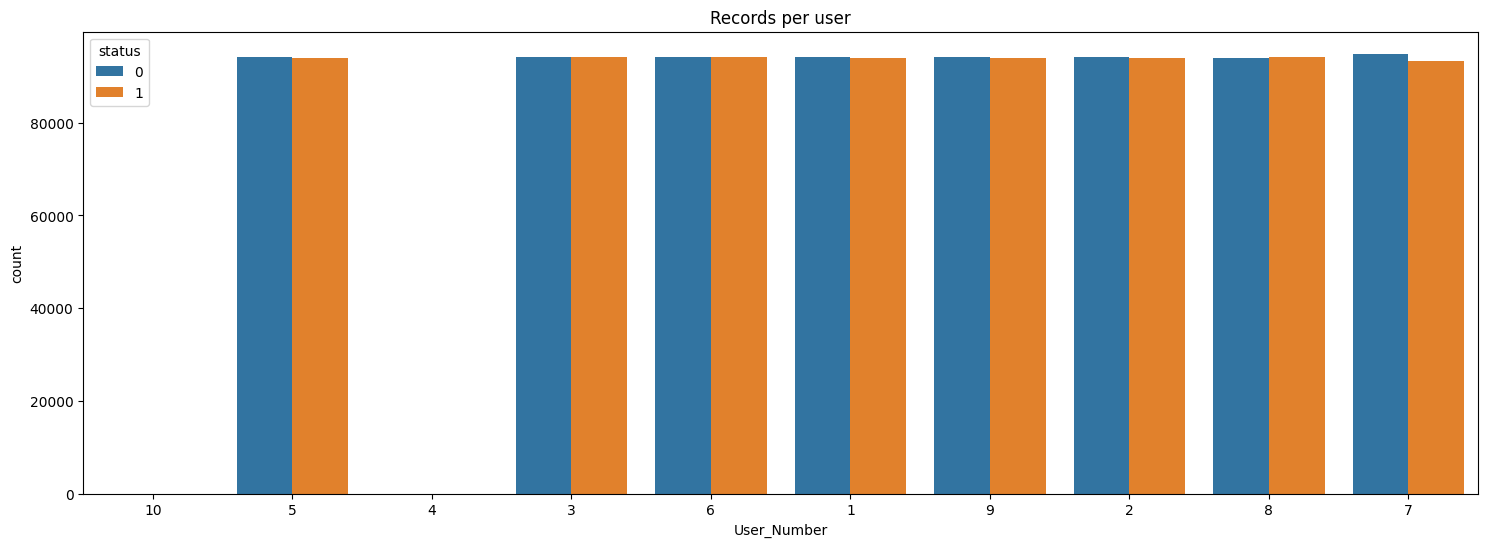

In [32]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = balanced_df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [33]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']], df.status, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17062, 200, 10) (17062, 1)
(5332, 200, 10) (5332, 1)


In [34]:
#Epoch 100

BATCH_SIZE = 128

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 10, 2)

In [35]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17062, 200, 10) (17062, 2) (5332, 200, 10) (5332, 2)


In [36]:
'''
X = balanced_df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = balanced_df['status'].values.reshape(-1, 1)
'''

"\nX = balanced_df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',\n       'Trunk_1', 'Trunk_2', 'Trunk_3']].values\ny = balanced_df['status'].values.reshape(-1, 1)\n"

In [37]:
'''
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
'''

'\nX_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)\nX_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )\nprint(X_train.shape, y_train.shape)\nprint(X_test.shape, y_test.shape)\n'

In [38]:
'''
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)
'''

'\nfrom sklearn.preprocessing import OneHotEncoder\n\nenc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)\nenc.fit(y_train)\n\ny_train_hot = enc.transform(y_train) \ny_test_hot = enc.transform(y_test) \ny_val_hot = enc.transform(y_val)\n'

In [39]:
'''
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]
'''

'\nn_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]\n'

In [42]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (n_timesteps,n_features),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200, 128)          71168     
                                                                 
 dropout_6 (Dropout)         (None, 200, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 198, 64)           24640     
                                                                 
 dropout_7 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6336)              0         
                                                      

In [43]:
epochs, batch_size = 20, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/20
134/134 [==============================] - 4s 23ms/step - loss: 0.3428 - accuracy: 0.9014 - val_loss: 0.4894 - val_accuracy: 0.9018
Epoch 2/20
134/134 [==============================] - 3s 19ms/step - loss: 0.3271 - accuracy: 0.9017 - val_loss: 0.4825 - val_accuracy: 0.9018
Epoch 3/20
134/134 [==============================] - 3s 19ms/step - loss: 0.3268 - accuracy: 0.9017 - val_loss: 0.4617 - val_accuracy: 0.9018
Epoch 4/20
134/134 [==============================] - 3s 19ms/step - loss: 0.3271 - accuracy: 0.9017 - val_loss: 0.4101 - val_accuracy: 0.9018
Epoch 5/20
134/134 [==============================] - 3s 20ms/step - loss: 0.3260 - accuracy: 0.9017 - val_loss: 0.3868 - val_accuracy: 0.9018
Epoch 6/20
134/134 [==============================] - 3s 21ms/step - loss: 0.3251 - accuracy: 0.9017 - val_loss: 0.3577 - val_accuracy: 0.9018
Epoch 7/20
134/134 [==============================] - 3s 20ms/step - loss: 0.3256 - accuracy: 0.9017 - val_loss: 0.3775 - val_accuracy: 0.9018

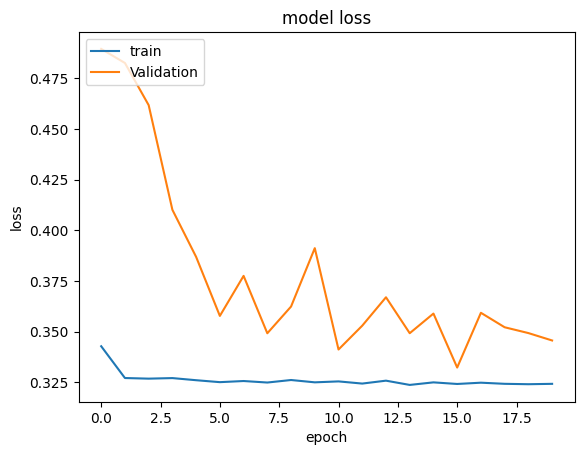

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

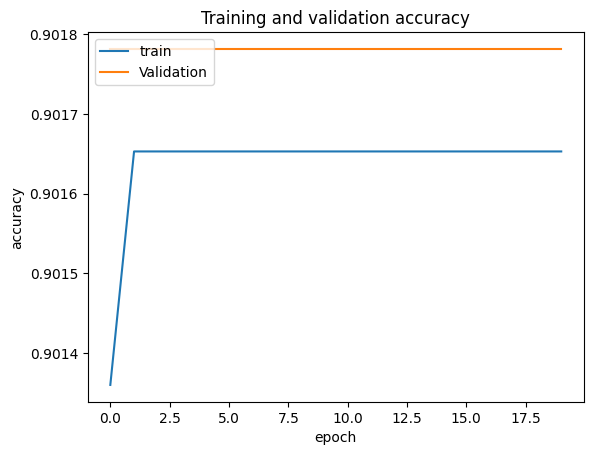

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

167/167 [==============================] - 2s 9ms/step
f1_score =  0.8551273913152845
0.9017254313578394
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4808
           1       0.00      0.00      0.00       524

    accuracy                           0.90      5332
   macro avg       0.45      0.50      0.47      5332
weighted avg       0.81      0.90      0.86      5332



I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
I:\anaconda3\envs\test01\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

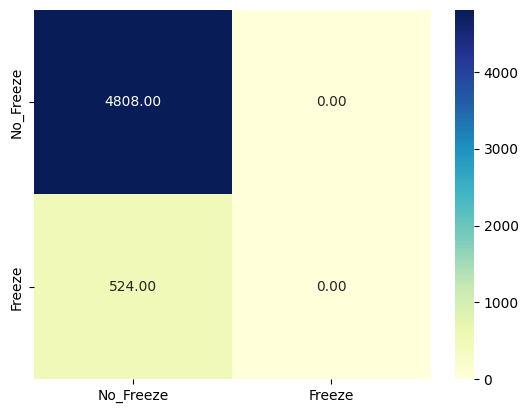

In [46]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')